# Logistic regression and variable selection

Maintainer: Zhaohu(Jonathan) Fan. Contact him at (psujohnny@gmail.com)

Note: This lab note is still WIP, let us know if you encounter bugs or issues.

# Table of Contents
1. [Objective](#1-objective)  
2. [Credit Card Default Data](#2-credit-card-default-data)  
3. [Logistic Regression](#3-logistic-regression)  
   3.1 [Train a logistic regression model with all variables](#31-train-a-logistic-regression-model-with-all-variables)  
   3.2 [Variable Selection](#32-variable-selection)  
   3.2.1 [Variable Selection with Stepwise Approach](#321-variable-selection-with-stepwise-approach)  
   3.2.2 [Variable selection with LASSO](#322-variable-selection-with-lasso)  

---

#### *Colab Notebook [Open in Colab](https://colab.research.google.com/drive/18YmCOFtSmE4Uk73MnFlfCsu5Vs1C7mLQ?usp=sharing)*
#### *Useful information about [Logistic Regression](https://yanyudm.github.io/Data-Mining-R/lecture/4.B_LogisticReg_VS.html)*




# 1 Objective

The objective of this case is to help you understand logistic regression (binary classification) and several important ideas, such as cross-validation the ROC curve, and the cutoff probability.

# 2 Credit Card Default Data

We will use a subset of the Credit Card Default Data (sample size $n = 12{,}000$) for this lab and illustration. Details of the full dataset ($n = 30{,}000$) can be found at: http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Think about what kinds of factors could cause people to fail to pay their credit card balance.

We first load the credit scoring data. It is easy to load comma-separated values (CSV).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

import warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# ----------------------------
# 1) Load data + basic prep
# ----------------------------
url = "https://yanyudm.github.io/Data-Mining-R/lecture/data/credit_default.csv"
credit_data = pd.read_csv(url)



Look at what information do we have.



In [6]:
# colnames(credit_data)
print("Columns:")
for i in range(0, len(credit_data.columns), 2):
    if i + 1 < len(credit_data.columns):
        print(f"{credit_data.columns[i]}\t{credit_data.columns[i+1]}")
    else:
        print(credit_data.columns[i])

Columns:
LIMIT_BAL	SEX
EDUCATION	MARRIAGE
AGE	PAY_0
PAY_2	PAY_3
PAY_4	PAY_5
PAY_6	BILL_AMT1
BILL_AMT2	BILL_AMT3
BILL_AMT4	BILL_AMT5
BILL_AMT6	PAY_AMT1
PAY_AMT2	PAY_AMT3
PAY_AMT4	PAY_AMT5
PAY_AMT6	default.payment.next.month


Let’s look at how many people were actually default in this sample.



In [9]:

# mean(credit_data$default.payment.next.month)
mean_default = credit_data["default.payment.next.month"].mean()
print(f"\nMean default.payment.next.month: {mean_default:.4f}")




Mean default.payment.next.month: 0.2193


The name of response variable is too long! I want to make it shorter by renaming. Recall the rename() function.



In [12]:
# rename default.payment.next.month -> default
credit_data = credit_data.rename(columns={"default.payment.next.month": "default"})


In [14]:
# str() and summary()
print("\n--- credit_data.info() ---")
credit_data.info()


--- credit_data.info() ---
<class 'pandas.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  12000 non-null  int64
 1   SEX        12000 non-null  int64
 2   EDUCATION  12000 non-null  int64
 3   MARRIAGE   12000 non-null  int64
 4   AGE        12000 non-null  int64
 5   PAY_0      12000 non-null  int64
 6   PAY_2      12000 non-null  int64
 7   PAY_3      12000 non-null  int64
 8   PAY_4      12000 non-null  int64
 9   PAY_5      12000 non-null  int64
 10  PAY_6      12000 non-null  int64
 11  BILL_AMT1  12000 non-null  int64
 12  BILL_AMT2  12000 non-null  int64
 13  BILL_AMT3  12000 non-null  int64
 14  BILL_AMT4  12000 non-null  int64
 15  BILL_AMT5  12000 non-null  int64
 16  BILL_AMT6  12000 non-null  int64
 17  PAY_AMT1   12000 non-null  int64
 18  PAY_AMT2   12000 non-null  int64
 19  PAY_AMT3   12000 non-null  int64
 20  PAY_AMT4   12000 non-null  int64


In [16]:
print("\n--- credit_data.describe(include='all') (rounded numeric to 4 dp) ---")
desc = credit_data.describe(include="all").T
num_cols = desc.select_dtypes(include=["number"]).columns
desc[num_cols] = desc[num_cols].round(4)
display(desc)



--- credit_data.describe(include='all') (rounded numeric to 4 dp) ---


,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,12000.0,167501.3333,130334.2124,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,12000.0,1.6029,0.4893,1.0,1.00,2.0,2.00,2.0
EDUCATION,12000.0,1.8443,0.7453,1.0,1.00,2.0,2.00,4.0
MARRIAGE,12000.0,1.5515,0.5208,1.0,1.00,2.0,2.00,3.0
AGE,12000.0,35.4997,9.2265,21.0,28.00,34.0,41.00,79.0
PAY_0,12000.0,-0.0158,1.1286,-2.0,-1.00,0.0,0.00,8.0
PAY_2,12000.0,-0.1280,1.1926,-2.0,-1.00,0.0,0.00,7.0
PAY_3,12000.0,-0.1667,1.1872,-2.0,-1.00,0.0,0.00,7.0
PAY_4,12000.0,-0.2256,1.1525,-2.0,-1.00,0.0,0.00,7.0
PAY_5,12000.0,-0.2678,1.1235,-2.0,-1.00,0.0,0.00,7.0


In [18]:
# factors -> categorical
for col in ["SEX", "EDUCATION", "MARRIAGE"]:
    credit_data[col] = credit_data[col].astype("category")

How about the variable type and summary statistics?



We see all variables are int, but we know that SEX, EDUCATION, MARRIAGE are categorical, we convert them to factor.



We omit other EDA, but you shouldn’t whenever you are doing data analysis.



# 3 Logistic Regression
Randomly split the data to training (80%) and testing (20%) datasets:

In [24]:
# Train/test split (80/20) similar to R's sample()
np.random.seed(123)  # for reproducibility
n = len(credit_data)
train_idx = np.random.choice(credit_data.index, size=int(0.80 * n), replace=False)

credit_train = credit_data.loc[train_idx].copy()
credit_test  = credit_data.drop(train_idx).copy()

## 3.1 Train a logistic regression model with all variables


In [27]:
# Fit logistic regression: glm(default ~ ., family=binomial, data=credit_train)
# Build a formula that treats selected columns as categorical (like factors in R)
y_col = "default"
x_cols = [c for c in credit_train.columns if c != y_col]
cat_cols = {"SEX", "EDUCATION", "MARRIAGE"}

rhs_terms = [f"C({c})" if c in cat_cols else c for c in x_cols]
full_formula = f"{y_col} ~ " + " + ".join(rhs_terms)

credit_glm0 = smf.glm(formula=full_formula, data=credit_train, family=sm.families.Binomial()).fit()
print(credit_glm0.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                 9600
Model:                            GLM   Df Residuals:                     9573
Model Family:                Binomial   Df Model:                           26
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4444.0
Date:                Fri, 27 Feb 2026   Deviance:                       8888.0
Time:                        15:08:17   Pearson chi2:                 1.12e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1204
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.0468      0.15

## 3.2  Variable Selection
### 3.2.1 Variable Selection with Stepwise Approach
We can use the same procedures of variable selection, i.e. forward, backward, and stepwise, for linear regression models. Caution: this will take a long period of time since the dimension of predictor variables is not very small and the sample size is large.

In [30]:
# ----------------------------
# Backward stepwise selection (AIC / BIC)
# step(credit_glm0)  and step(credit_glm0, k=log(n))
# ----------------------------
def bic_llf_like_r(res):
    """BIC comparable to R's BIC for GLM: -2*llf + log(n)*df_model_with_intercept"""
    nobs = res.nobs
    df = res.df_model + 1  # +1 for intercept
    return -2.0 * res.llf + np.log(nobs) * df

def fit_glm_from_terms(terms, data):
    formula = f"{y_col} ~ " + (" + ".join(terms) if len(terms) > 0 else "1")
    return smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()

def backward_stepwise(initial_terms, data, criterion="aic", verbose=True):
    """
    Backward elimination: iteratively remove one term at a time to improve criterion.
    criterion in {"aic","bic"}.
    """
    terms = list(initial_terms)
    current = fit_glm_from_terms(terms, data)

    def score(model):
        if criterion.lower() == "aic":
            return model.aic
        elif criterion.lower() == "bic":
            return bic_llf_like_r(model)
        else:
            raise ValueError("criterion must be 'aic' or 'bic'")

    current_score = score(current)

    if verbose:
        print(f"\n[Stepwise {criterion.upper()}] start: score={current_score:.4f}, terms={len(terms)}")

    improved = True
    while improved and len(terms) > 0:
        improved = False
        best_model = None
        best_terms = None
        best_score = current_score

        # try removing each term once
        for j in range(len(terms)):
            candidate_terms = terms[:j] + terms[j+1:]
            candidate_model = fit_glm_from_terms(candidate_terms, data)
            candidate_score = score(candidate_model)

            if candidate_score < best_score - 1e-8:  # strict improvement
                best_score = candidate_score
                best_model = candidate_model
                best_terms = candidate_terms

        if best_model is not None:
            terms = best_terms
            current = best_model
            current_score = best_score
            improved = True
            if verbose:
                print(f"  -> remove 1 term, score={current_score:.4f}, remaining terms={len(terms)}")

    return current, terms

# Backward selection by AIC (like step() default)
credit_glm_back, back_terms_aic = backward_stepwise(rhs_terms, credit_train, criterion="aic", verbose=True)
print("\n--- credit_glm_back (AIC-backward) summary ---")
print(credit_glm_back.summary())

print(f"\ncredit_glm_back deviance: {credit_glm_back.deviance:.4f}")
print(f"AIC(credit_glm_back): {credit_glm_back.aic:.4f}")
print(f"BIC(credit_glm_back): {bic_llf_like_r(credit_glm_back):.4f}")

# Backward selection by BIC (like step(..., k=log(n)))
credit_glm_back_BIC, back_terms_bic = backward_stepwise(rhs_terms, credit_train, criterion="bic", verbose=True)
print("\n--- credit_glm_back_BIC (BIC-backward) summary ---")
print(credit_glm_back_BIC.summary())

print(f"\ncredit_glm_back_BIC deviance: {credit_glm_back_BIC.deviance:.4f}")
print(f"AIC(credit_glm_back_BIC): {credit_glm_back_BIC.aic:.4f}")
print(f"BIC(credit_glm_back_BIC): {bic_llf_like_r(credit_glm_back_BIC):.4f}")


[Stepwise AIC] start: score=8941.9653, terms=23
  -> remove 1 term, score=8939.9659, remaining terms=22
  -> remove 1 term, score=8937.9732, remaining terms=21
  -> remove 1 term, score=8935.9882, remaining terms=20
  -> remove 1 term, score=8934.0061, remaining terms=19
  -> remove 1 term, score=8932.6823, remaining terms=18
  -> remove 1 term, score=8932.0253, remaining terms=17
  -> remove 1 term, score=8931.6927, remaining terms=16
  -> remove 1 term, score=8931.3909, remaining terms=15
  -> remove 1 term, score=8929.7918, remaining terms=14

--- credit_glm_back (AIC-backward) summary ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                 9600
Model:                            GLM   Df Residuals:                     9582
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Meth

## 3.2.2 Variable selection with LASSO
Be careful that LASSO does require x to be numeric matrix. Therefore, we need to manually convert categorical variable (“SEX”, “EDUCATION” and “MARRIAGE”) to dummy variable. For simplicity, only if you have evidence that the categorical variable has monotonic relationship to response can you directly convert it to numeric by using as.numeric(). For example, the probability of default increases/decreases as EDUCATION level goes from 1 to 4. This can be seen from the two-way contingency table by calculating the default proportion at each education level.

Here I will show how to convert categorical variable to dummy variables.

In [37]:
# ------------------------------------------------------------
# Read data + treat selected columns as categorical ("factor")
# + dummy encode + train/test split + LASSO (with scaling)
# ------------------------------------------------------------
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# 1) Read data
url = "https://yanyudm.github.io/Data-Mining-R/lecture/data/credit_default.csv"
credit_data = pd.read_csv(url).rename(columns={"default.payment.next.month": "default"})

print("Mean default rate:", f"{credit_data['default'].mean():.4f}")

# 2) Treat categorical columns like R's as.factor()
for col in ["SEX", "EDUCATION", "MARRIAGE"]:
    credit_data[col] = credit_data[col].astype("category")

# 3) Dummy variables (R: model.matrix(~ ., data=credit_data))
X_raw = credit_data.drop(columns=["default"])
y = credit_data["default"].astype(int).values

# get_dummies will create dummy indicators for the categorical columns
X = pd.get_dummies(X_raw, drop_first=True)

print("\n--- First 5 rows of dummy-encoded X ---")
display(X.head())

# 4) Train/test split (same spirit as your random sampling)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=123, shuffle=True, stratify=y
)

print(f"\nTrain X shape: {X_train.shape}, Train y shape: {y_train.shape}")
print(f"Test  X shape: {X_test.shape},  Test  y shape: {y_test.shape}")

# 5) Implement LASSO logistic regression (scaling recommended for L1 penalty)
credit_lasso = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", LogisticRegression(
        penalty="l1",
        solver="saga",
        C=1.0,          # shrinkage strength (tune later with CV if desired)
        max_iter=10000,
        n_jobs=-1
    ))
])

credit_lasso.fit(X_train, y_train)

# 6) Output intercept + "nonzero" coefficients (use tolerance, not coef != 0)
model = credit_lasso.named_steps["model"]
feature_names = X.columns.to_list()

print(f"\nIntercept (standardized X): {model.intercept_[0]:.6f}")

coefs = pd.Series(model.coef_.ravel(), index=feature_names)

tol = 1e-4  # practical "nonzero" threshold
nonzero = coefs[coefs.abs() > tol].sort_values(key=np.abs, ascending=False)

print(f"Number of nonzero coefficients (|coef| > {tol:g}): {nonzero.shape[0]}")
display(nonzero)


Mean default rate: 0.2193

--- First 5 rows of dummy-encoded X ---


,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_2,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
0,290000,26,0,0,0,0,-1,-1,18125,20807,...,3000,3015,23473,1148,True,True,False,False,True,False
1,20000,51,-1,-1,-2,-1,-1,-2,780,0,...,2280,0,0,0,False,True,False,False,True,False
2,280000,29,-2,-2,-2,-2,-2,-2,10660,5123,...,2510,591,14994,5000,False,False,False,False,True,False
3,280000,47,0,0,0,0,0,0,269124,266163,...,6281,4403,3532,3510,True,False,False,False,True,False
4,20000,24,0,0,0,0,0,0,17924,18475,...,1181,1000,500,500,False,True,False,False,True,False



Train X shape: (9600, 26), Train y shape: (9600,)
Test  X shape: (2400, 26),  Test  y shape: (2400,)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)



Intercept (standardized X): -1.487715
Number of nonzero coefficients (|coef| > 0.0001): 24


PAY_0          0.690733
BILL_AMT1     -0.434784
BILL_AMT2      0.315602
PAY_AMT2      -0.184359
BILL_AMT4     -0.180500
BILL_AMT5      0.173506
PAY_AMT1      -0.136091
EDUCATION_4   -0.134674
LIMIT_BAL     -0.106660
PAY_3          0.082553
PAY_5          0.078378
PAY_AMT3      -0.077576
EDUCATION_3   -0.071955
MARRIAGE_2    -0.068462
SEX_2         -0.062550
PAY_2          0.060422
PAY_AMT4      -0.060185
AGE            0.059915
EDUCATION_2   -0.053317
PAY_AMT5      -0.042827
PAY_AMT6      -0.038364
PAY_4          0.037415
BILL_AMT3      0.015565
BILL_AMT6      0.013810
dtype: float64

[1.00000000e-04 2.51188643e-04 6.30957344e-04 1.58489319e-03
 3.98107171e-03 1.00000000e-02 2.51188643e-02 6.30957344e-02
 1.58489319e-01 3.98107171e-01 1.00000000e+00 2.51188643e+00
 6.30957344e+00 1.58489319e+01 3.98107171e+01 1.00000000e+02]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1780: FutureWarning: The default value for l1_ratios will change from None to (0.0,) in version 1.10. From version 1.10 onwards, only array-like with values in [0, 1] will be allowed, None will be forbidden. To avoid this warning, explicitly set a value, e.g. l1_ratios=(0,).
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1811: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratios' instead. Use l1_ratios=(0,) instead of penalty='l2'  and l1_ratios=(1,) instead of penalty='l1'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1823: FutureWarning: The fitted attributes of LogisticRegressionCV will be simplified in scikit-learn 1.10 to remove redundancy. Set`use_legacy_attributes=False` to enable the new behav

Cs tried: [1.00000000e-04 2.51188643e-04 6.30957344e-04 1.58489319e-03
 3.98107171e-03 1.00000000e-02 2.51188643e-02 6.30957344e-02
 1.58489319e-01 3.98107171e-01 1.00000000e+00 2.51188643e+00
 6.30957344e+00 1.58489319e+01 3.98107171e+01 1.00000000e+02]
Best C chosen by CV: 6.30957


,C,Mean CV Accuracy,Mean CV Misclassification Error
0,0.000100,0.780625,0.219375
1,0.000251,0.780625,0.219375
2,0.000631,0.780625,0.219375
3,0.001585,0.781146,0.218854
4,0.003981,0.789062,0.210938
5,0.010000,0.803542,0.196458
6,0.025119,0.809896,0.190104
7,0.063096,0.811771,0.188229
8,0.158489,0.813333,0.186667
9,0.398107,0.813437,0.186563


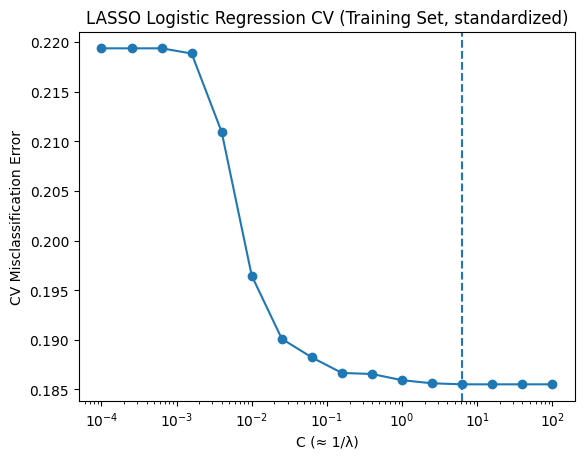


Intercept (standardized X): -1.489563
Number of nonzero coefficients (|coef| > 0.0001): 26


PAY_0          0.690234
BILL_AMT1     -0.476271
BILL_AMT2      0.356743
BILL_AMT4     -0.225190
BILL_AMT5      0.198862
PAY_AMT2      -0.187789
PAY_AMT1      -0.144809
EDUCATION_4   -0.136164
LIMIT_BAL     -0.106911
PAY_3          0.081742
PAY_5          0.079683
EDUCATION_3   -0.073524
PAY_AMT3      -0.072685
MARRIAGE_2    -0.069229
PAY_AMT4      -0.066624
SEX_2         -0.063156
PAY_2          0.061428
AGE            0.060410
EDUCATION_2   -0.055023
PAY_AMT5      -0.043154
PAY_AMT6      -0.038890
PAY_4          0.037697
BILL_AMT3      0.035524
BILL_AMT6      0.015014
PAY_6         -0.001958
MARRIAGE_3     0.000346
dtype: float64


Train predicted prob: min=0.0000, mean=0.2194, max=0.9946
Test  predicted prob: min=0.0000, mean=0.2186, max=0.9937


In [39]:
# ------------------------------------------------------------
# LASSO + Cross-validation to choose shrinkage parameter (C)
# (glmnet cv.glmnet analogue; uses TRAINING set only)
# ------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

Cs = np.logspace(-4, 2, 16)   # 1e-4 ... 1e2 (wide, robust)
print(Cs)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

lasso_cv = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", LogisticRegressionCV(
        Cs=Cs,
        cv=cv,
        penalty="l1",
        solver="saga",
        scoring="accuracy",     # closest to type.measure="class" (misclassification)
        max_iter=10000,
        n_jobs=-1,
        refit=True
    ))
])

# Fit CV model on training data only
lasso_cv.fit(X_train, y_train)

model = lasso_cv.named_steps["model"]
best_C = float(model.C_[0])

print("Cs tried:", Cs)
print(f"Best C chosen by CV: {best_C:.6g}")

# ------------------------------------------------------------
# Summarize CV performance across C values
# model.scores_ is a dict keyed by class label; take whichever key exists
# ------------------------------------------------------------
scores_dict = model.scores_
key = 1 if 1 in scores_dict else list(scores_dict.keys())[0]

mean_cv_acc = scores_dict[key].mean(axis=0)   # mean over folds
mean_cv_err = 1 - mean_cv_acc

cv_table = pd.DataFrame({
    "C": Cs,
    "Mean CV Accuracy": mean_cv_acc,
    "Mean CV Misclassification Error": mean_cv_err
})
display(cv_table)

plt.figure()
plt.semilogx(Cs, mean_cv_err, marker="o")
plt.axvline(best_C, linestyle="--")
plt.xlabel("C (≈ 1/λ)")
plt.ylabel("CV Misclassification Error")
plt.title("LASSO Logistic Regression CV (Training Set, standardized)")
plt.show()

# ------------------------------------------------------------
# Coefficients at the best C (refit=True => model is already refit)
# ------------------------------------------------------------
feature_names = X.columns.to_list()
coefs = pd.Series(model.coef_.ravel(), index=feature_names)

tol = 1e-4
nonzero = coefs[coefs.abs() > tol].sort_values(key=np.abs, ascending=False)

print(f"\nIntercept (standardized X): {model.intercept_[0]:.6f}")
print(f"Number of nonzero coefficients (|coef| > {tol:g}): {nonzero.shape[0]}")
display(nonzero)

# ------------------------------------------------------------
# Predicted probabilities (optional)
# ------------------------------------------------------------
p_train = lasso_cv.predict_proba(X_train)[:, 1]
p_test  = lasso_cv.predict_proba(X_test)[:, 1]

print(f"\nTrain predicted prob: min={p_train.min():.4f}, mean={p_train.mean():.4f}, max={p_train.max():.4f}")
print(f"Test  predicted prob: min={p_test.min():.4f}, mean={p_test.mean():.4f}, max={p_test.max():.4f}")


Best C (chosen by CV): 6.30957
Optimal lambda (≈ 1/C): 0.158489


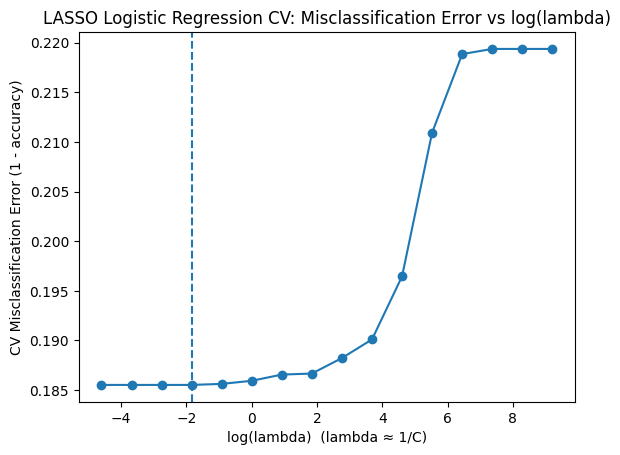


Intercept (standardized X): -1.489583
Number of nonzero coefficients (|coef| > 0.0001): 26

--- Nonzero coefficients at optimal lambda ---


,0
PAY_0,0.690212
BILL_AMT1,-0.477484
BILL_AMT2,0.356847
BILL_AMT4,-0.225085
BILL_AMT5,0.197653
PAY_AMT2,-0.188292
PAY_AMT1,-0.144996
EDUCATION_4,-0.136163
LIMIT_BAL,-0.106863
PAY_3,0.081682


In [7]:
# Convert C -> lambda (up to proportionality): lambda = 1/C
lambdas = 1.0 / Cs
log_lambdas = np.log(lambdas)

# Identify optimal lambda (min CV error) <=> best C (max accuracy)
best_C = float(model.C_[0])
lambda_opt = 1.0 / best_C

min_idx = int(np.argmin(mean_cv_err))
lambda_min_curve = lambdas[min_idx]  # should match lambda_opt (same grid)

print(f"Best C (chosen by CV): {best_C:.6g}")
print(f"Optimal lambda (≈ 1/C): {lambda_opt:.6g}")

# Plot: misclassification error vs log(lambda)
plt.figure()
plt.plot(log_lambdas, mean_cv_err, marker="o")
plt.axvline(np.log(lambda_opt), linestyle="--")
plt.xlabel("log(lambda)  (lambda ≈ 1/C)")
plt.ylabel("CV Misclassification Error (1 - accuracy)")
plt.title("LASSO Logistic Regression CV: Misclassification Error vs log(lambda)")
plt.show()

# ------------------------------------------------------------
# Coefficients at optimal lambda (refit=True => already refit at best C)
# ------------------------------------------------------------
feature_names = X.columns.to_list()
coef_std = pd.Series(model.coef_.ravel(), index=feature_names)

# Practical sparsity threshold
tol = 1e-4
coef_nonzero = coef_std[coef_std.abs() > tol].sort_values(key=np.abs, ascending=False)

print(f"\nIntercept (standardized X): {model.intercept_[0]:.6f}")
print(f"Number of nonzero coefficients (|coef| > {tol:g}): {coef_nonzero.shape[0]}")
print("\n--- Nonzero coefficients at optimal lambda ---")
display(coef_nonzero)


In [ ]:
%%shell
jupyter nbconvert --to html ///content/4_B_Logistic_regression_and_prediction.ipynb

[NbConvertApp] Converting notebook ///content/4_B_Logistic_regression_and_prediction.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 483689 bytes to /content/4_B_Logistic_regression_and_prediction.html
